Jeśli używamy notebooka lokalnie należy zaistalowac qiskit https://www.ibm.com/quantum/qiskit

``pip install qiskit``

``pip install qiskit-ibm-runtime``

Dla ładniejszej wizualizacji obwodów:
``pip install pylatexenc``

In [18]:
import warnings
warnings.filterwarnings("ignore")
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.visualization import array_to_latex

In [29]:
# Tworzymy prosty obwód kwantowy produkujący stan GHZqnumber=3
qc= QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
display(qc.draw())

┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

### Uruchomienie lokalne

In [4]:
#używamy dokładnego symulatora statevector lokalnie
state = Statevector.from_instruction(qc)

In [5]:
# można zobaczyć wyliczone amplitudy (numeryczne wartości w postaci zespolonej)
print(state)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


In [6]:
for x in range(pow(2,qnumber)):
    print(x,state[x])

0 (0.7071067811865475+0j)
1 0j
2 0j
3 0j
4 0j
5 0j
6 0j
7 (0.7071067811865475+0j)


In [16]:
state.draw('latex')

<IPython.core.display.Latex object>

In [14]:
array_to_latex(state)

<IPython.core.display.Latex object>

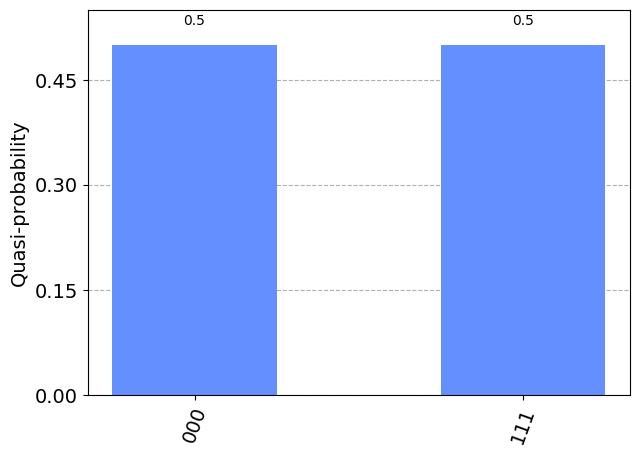

In [9]:
# można też narysować histogram z wyliczonymi prawdopodobieństwami (wynik idealny) 
ideal_distribution = state.probabilities_dict()
plot_histogram(ideal_distribution)

Lokalne użycie prymitywu *Sampler*

Powyższe sposoby można stosować do mniejszych obwodów, aby podglądnąć dokładny stan (proszę zauważyć, że powyżej nie dodaliśmy bramek pomiaru !). 

W prawdziwym urządzeniu takie obliczenie nie jest to możliwe.

Dlatego też, w aktualnej wersji qiskita  wprowadzono dwa podstawowe sposoby (https://docs.quantum.ibm.com/api/qiskit/primitives) do uzyskiwania danych w sposób zgodny z mechaniką kwantową z uruchomienie obwodu kwantowego : 
 - *Estimator*  - szacujący wartość oczekiwaną pewnej obserwabli (wykracza poza ten kurs) 
 - *Sampler* - losujący wyniki zgodnie z zasadami pomiaru kwantowego.

In [17]:
# dodajemy pomiar
qc.measure_all()
display(qc.draw())

┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2

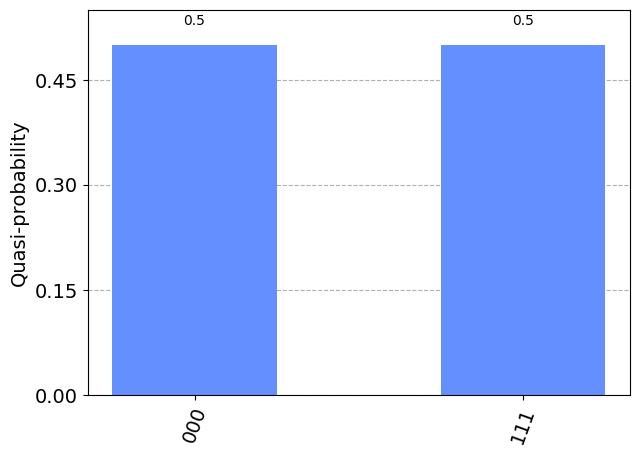

In [10]:
from qiskit.primitives import Sampler as PSampler
# jeśli do funkcji run() przekażemy tylko obwód to zwróci rezultat z wyliczonymi dokładnymi
#prawdopodobieństwami
results = PSampler().run(qc).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

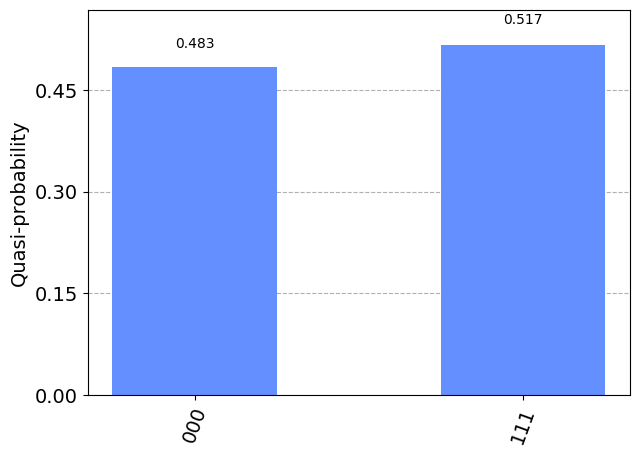

In [11]:
# jeśli do funkcji run() dodamy opcję shots to wynik jest próbkowany tę liczbę razy 
# losowanie na komputerze klasycznym zgodnie  wyliczonym prawdopodobieństwem 
results = PSampler().run(qc,shots=1024).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

### Uruchomienie na infrastrukturze IBM
uwaga: niestety mogą być przestoje

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService
#jeśli zapisaliśmy token na dysku, wystarczy go wczytać
service = QiskitRuntimeService()

In [20]:
# Wybór symulatora w chmurze IBM (nie zużywa "Monthly usage")
# dostępne symulatory https://quantum.ibm.com/services/resources?resourceType=simulators
backend=service.backend('ibmq_qasm_simulator')
backend.name

'ibmq_qasm_simulator'

In [21]:
# uruchomienie joba  - możemy użyć prymitywu Sampler 
# przy użyciu qiskit_ibm_runtime używamy  Sampler-a działającego na infrastrukturze IBM
# uwaga: inaczej niż przy użyciu qiskit.primitives, gdzie uruchomienie jest lokalne

from qiskit_ibm_runtime import  Batch, Sampler
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=[qc],
        shots=100,
    )
    result_sim = job.result()

In [15]:
# jeśli zadanie czeka długo w kolejce, 
# można będzie potem  wyciągnąć wyniki ze starego joba po jego numerze z https://quantum.ibm.com/jobs
#result_sim = service.job('myJobID').result()

In [22]:
#quasi_dists zawiera słownik  {stan_bazowy_dziesiątkowo: prawdopodobieństwo}, tutaj możliwe stany to
# 0 czyli 000 oraz 7 czyli 111 
print(result_sim)

SamplerResult(quasi_dists=[{7: 0.51, 0: 0.49}], metadata=[{'shots': 100, 'circuit_metadata': {}}])


In [18]:
# wybór prawdziwego urządzenia kwantowego (uwaga: "zjada" minuty - należy monitorować w dashboardzie)
# dostępne urządzenia:
# https://quantum.ibm.com/services/resources?resourceType=systems
backend=service.backend('ibm_osaka')
backend.name

'ibm_osaka'

In [19]:
# transpilacja = przetłumaczenie obwodu na bramki wspierane przez urządzenie
# dla ibm_osaka można to sprawdzić tutaj https://quantum.ibm.com/services/resources?system=ibm_osaka
# możliwe jest ustawienie poziomu optymalizacji od 0 do 3
optimization_level=0
t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
print(f"optimization_level={optimization_level}: ", t_qc.count_ops())

optimization_level=0:  OrderedDict([('rz', 51), ('sx', 18), ('ecr', 5), ('x', 5), ('measure', 3), ('barrier', 1)])


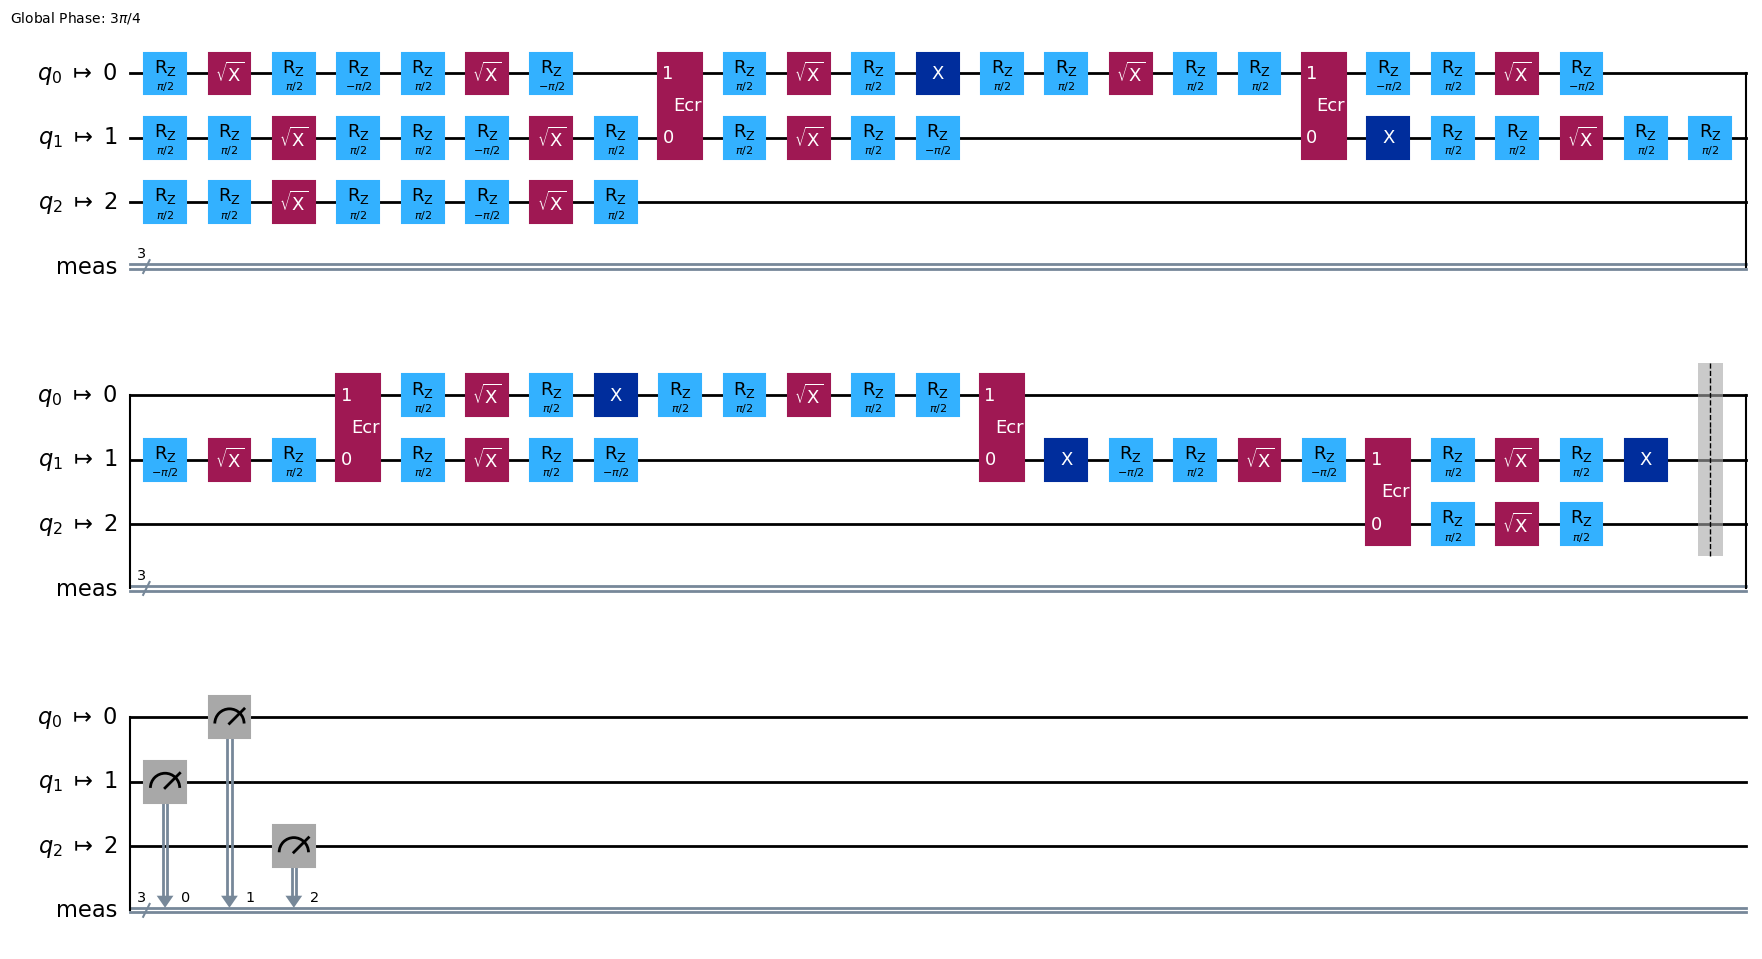

In [20]:
# można obejrzeć wynik traspilacji - ECR to zoptymalizowana bramka CNOT
#https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ECRGate
# brak optymalizacji powoduje wystąpienie 5 ciu bramek ECR (nie ma połączenia pomiędzy qbitami 0 i 2)
t_qc.draw(output="mpl", style="iqp", idle_wires=False)

In [24]:
# transpilacja = przetłumaczenie obwodu na bramki wspierane przez urządzenie
# dla ibm_osaka można to sprawdzić tutaj https://quantum.ibm.com/services/resources?system=ibm_osaka
# możliwe jest ustawienie poziomu optymalizacji od 0 do 3
optimization_level=3
t_qc = transpile(qc, backend, optimization_level=optimization_level, seed_transpiler=0)
print(f"optimization_level={optimization_level}: ", t_qc.count_ops())

optimization_level=3:  OrderedDict([('u', 4), ('measure', 3), ('cx', 2), ('barrier', 1)])


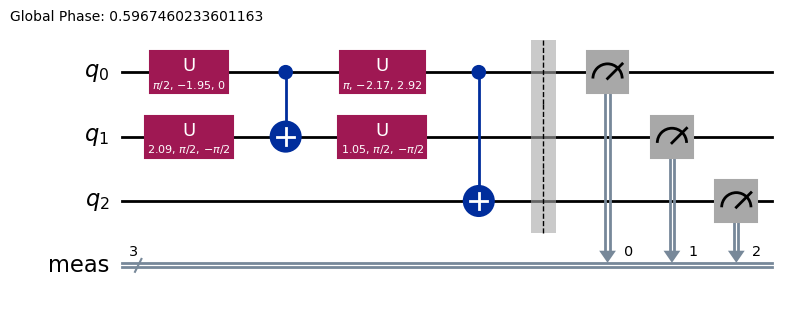

In [25]:
# można obejrzeć wynik traspilacji - ECR to zoptymalizowana bramka CNOT
#https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ECRGate

t_qc.draw(output="mpl", style="iqp", idle_wires=False)

In [26]:
# uruchomienie - uwaga: podajemy przetranspilowany obwód (t_qc)
from qiskit_ibm_runtime import  Batch, Sampler
with Batch(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(
        circuits=[t_qc],
        shots=100,
    )
    result_dev = job.result()

In [18]:
# jeśli zadanie czeka długo w kolejce, 
# można będzie potem  wyciągnąć wyniki ze starego joba po jego numerze z https://quantum.ibm.com/jobs

# result_dev = service.job('myJobID').result()

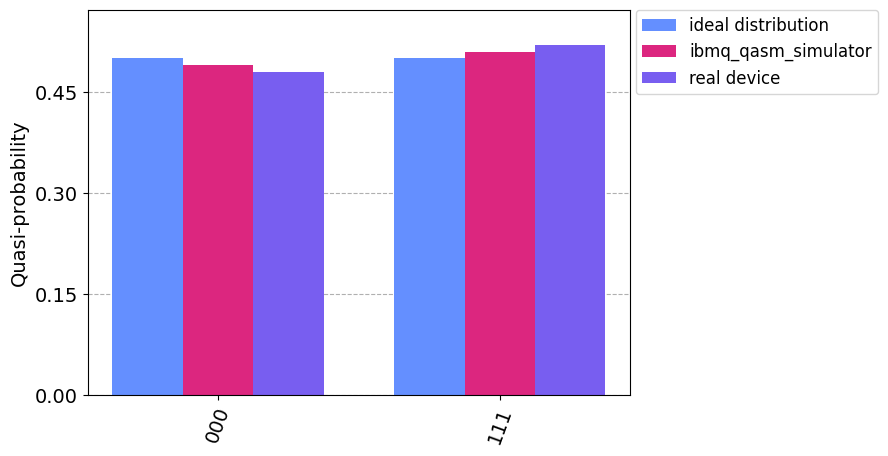

In [27]:
# porównanie histogramów - w przypadku urządzenia kwantowego pojawiły się stany,
# które nigdy nie powinny wyjść z teoretycznych wyliczeń
binary_prob = [ideal_distribution, result_sim.quasi_dists[0].binary_probabilities(), result_dev.quasi_dists[0].binary_probabilities()]
plot_histogram(
    binary_prob,
    bar_labels=False,
    legend=[
        "ideal distribution",
        "ibmq_qasm_simulator",
        "real device",
    ],
)

In [28]:
import qiskit
qiskit.version.get_version_info()

'1.0.2'

In [26]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.21.1'